In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
data_folder = '~/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,
                               download=True,
                               train=True)
tr_images, tr_targets = fmnist.data, fmnist.targets

In [2]:
class FmnistDataset(Dataset):
    def __init__(self,x,y):
        x=x.float()/255
        x=x.view(-1,28*28)
        self.x, self.y = x,y
    def __getitem__(self, ix):
        x,y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [3]:
def get_data():
    train = FmnistDataset(tr_images,tr_targets)
    trn_dl= DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [4]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000,10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01)
    return model, loss_fn, optimizer

In [5]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction=model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [6]:
#@torch.no_grad()
#def accuracy(x,y,model):
#    model.eval()
#    prediction=model(x)
#    max_values, argmaxes = prediction.max(-1)
#    is_correct = argmaxes == y
#    return is_correct.cpu().numpy().tolist()

def accuracy(x,y,model):
    model.eval()
    with torch.no_grad():
        prediction=model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [7]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [],[]
num_epochs = 30
for epoch in range(num_epochs):
    print(epoch)
    epoch_losses, epoch_accuracies = [],[]
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
        
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        is_correct = accuracy(x,y,model)
        epoch_accuracies.extend(is_correct)      
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


C:\Users\eshlom\AppData\Local\Temp\1\ipykernel_25320\2832233489.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


Final Training Accuracy was 0.91


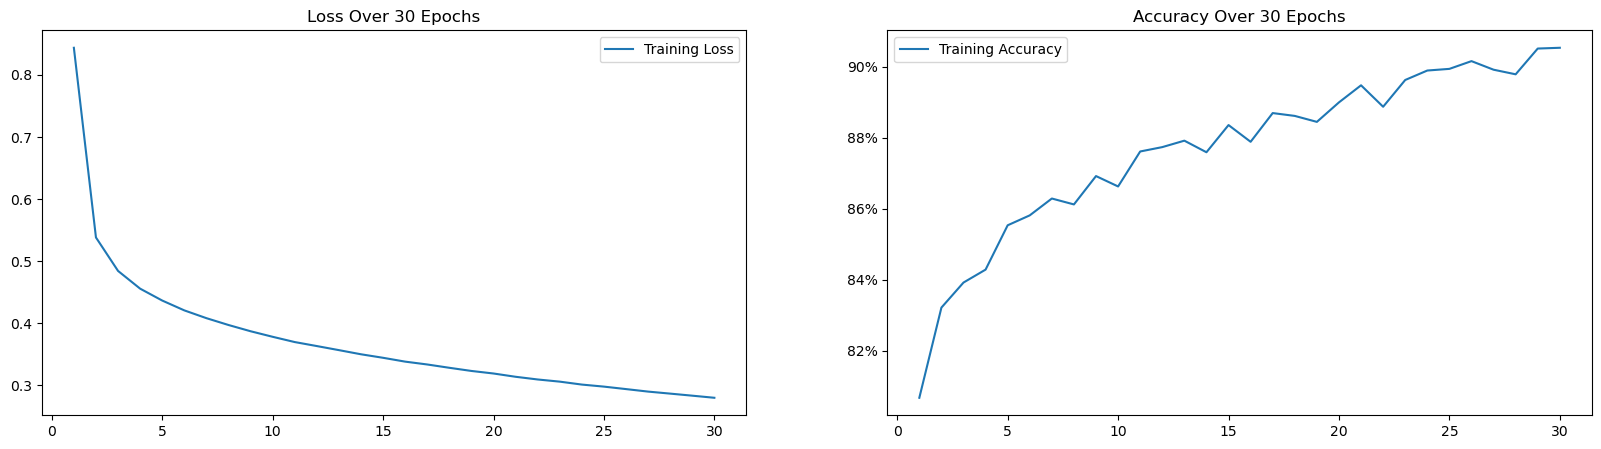

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = np.arange(num_epochs)+1
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.title('Loss Over 30 Epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy Over 30 Epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

print(f'Final Training Accuracy was {round(accuracies[-1], 2)}')